<a href="https://colab.research.google.com/github/highbridge1029-glitch/guest/blob/master/machine_learning/basics/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 機械学習の第一歩：回帰分析で市場を予測する

このノートブックでは、実際の金融市場データ（日経平均、NVIDIA株、ビットコインなど）を用いて、機械学習の最も基礎的かつ重要な概念である **「回帰分析（Regression Analysis）」** を体験します。

## 🧠 機械学習の本質とは？
一般的なプログラミングでは、人間が「ルール」を記述し、コンピュータがそれを実行します（例：`もし価格が100円上がったら売る`）。
一方、**機械学習**においては、人間からは「データ（過去の事実）」を与え、コンピュータ（機械）はそのデータに含まれる **「法則性（ルール）」を導きます** 。

### なぜ「回帰」が重要なのか？
現代のAI、例えばChatGPTのような大規模言語モデルも、画像生成AIも、突き詰めれば **「入力データ $x$ に対して、最適な出力 $y$ を返す関数 $f(x)$ を学習している」** と言えます。
* **線形回帰**: $y = ax + b$ （直線の関係を見つける）
* **非線形回帰**: $y = ax^3 + bx^2 + \dots$ （曲線の関係を見つける）
* **ディープラーニング**: 数億個のパラメータを持つ超複雑な非線形関数

この教材で行う「曲線のあてはめ」は、現代の高度なAIが行っている学習プロセスの最もシンプルな原形です。

## 🎯 過去への適合 vs 新たなデータへの汎化
データを分析する際に、これらのトレードオフを実感してもらいたいと思います。
1.  **表現力**: モデルを複雑にすれば（次数を上げれば）、過去のデータのどんな細かい動き（ノイズ）も再現できます。
2.  **汎化性能**: しかし、過去に**適合しすぎた（Overfitting）** モデルは、未知の未来に対しては脆く、デタラメな予測をしがちです。

ここでは、次数のパラメータを変更しながら、**「過去の説明に完璧なモデルが、必ずしも未来の予測に優れているわけではない」** という、AI開発における最も重要な教訓を視覚的に体験してください。


In [1]:
# @title ⚙️ ライブラリのインストールとインポート { display-mode: "form" }
!pip install -q yfinance termcolor

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from termcolor import colored
import seaborn as sns

# スタイルの設定
sns.set(style="whitegrid")
# フォントサイズなどのプロット設定
plt.rcParams['figure.figsize'] = [14, 7]
plt.rcParams['lines.linewidth'] = 2

print(colored("ライブラリの準備が完了しました。", "green"))

ライブラリの準備が完了しました。


## 📊 使用する数式モデル

ここでは日経平均・為替といった時系列データを、以下の多項式モデルで表現します。
$$\hat{y} = w_0 + w_1 x + w_2 x^2 + \dots + w_d x^d$$
* $y$: 価格
* $x$: 時間
* $d$: **次数（Degree）**
    * $d=1$: 単純な直線（トレンド）
    * $d \ge 3$: 複雑な波形（サイクル）

データ取得中: Bitcoin (BTC-JPY) ...


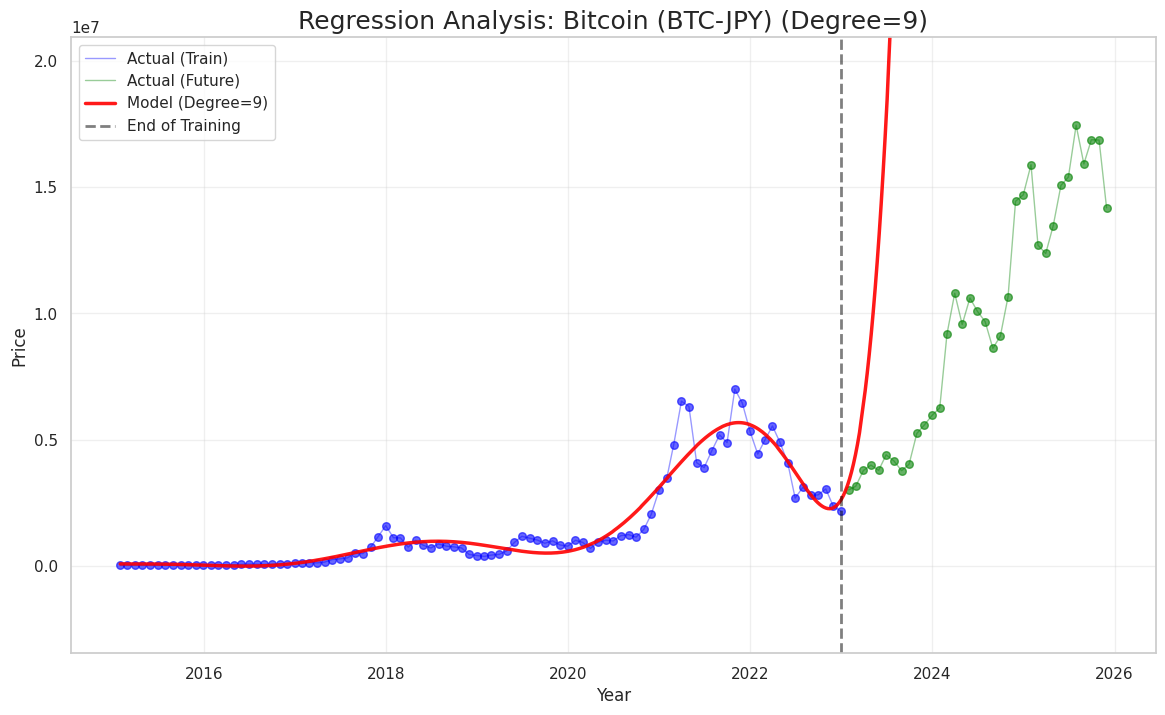

------------------------------------------------------------
📊 分析レポート (次数: 9)

🧮 推定された数式モデル:
y = 7.74e+04  -3.35e-03 * x^1  -8.08e-02 * x^2  -1.30e+00 * x^3  -1.25e+01 * x^4
      + 1.26e+00 * x^5  -4.57e-02 * x^6 + 7.72e-04 * x^7  -6.18e-06 * x^8
      + 1.90e-08 * x^9
※ x は学習開始からの経過月数、表記は指数表記 (例: 1.2e+03 = 1200) です。

学習データ誤差 (RMSE): 523,045.61
テストデータ誤差 (RMSE): 1,392,736,500.82
------------------------------------------------------------
⚠️ [過学習の警告] Overfitting Detected!
次数が大きすぎるため、係数が非常に大きくなっている可能性があります。


In [12]:
# @title 🕹️ 分析パラメータの設定と実行 { display-mode: "form" }

# --------------------------
# フォーム設定
# --------------------------

target_asset = "Bitcoin (BTC-JPY)" # @param ["Nikkei 225 (^N225)", "NVIDIA (NVDA)", "USD/JPY (JPY=X)", "Gold/JPY (Calc)", "Bitcoin (BTC-JPY)"]
degree = 9 # @param {type:"slider", min:1, max:15, step:1}
train_start_year = 2015 # @param {type:"integer"}
train_end_year = 2022 # @param {type:"integer"}

# --------------------------
# データ取得と前処理関数
# --------------------------

def get_data(asset_name, start_year):
    """yfinanceからデータを取得し月次にリサンプリングする"""
    start_date = f"{start_year}-01-01"
    end_date = (datetime.now().replace(day=1) - timedelta(days=1)).strftime('%Y-%m-%d') # 先月末まで

    # ティッカーシンボルのマッピング
    tickers = {
        "Nikkei 225 (^N225)": "^N225",
        "NVIDIA (NVDA)": "NVDA",
        "USD/JPY (JPY=X)": "JPY=X",
        "Bitcoin (BTC-JPY)": "BTC-JPY",
        "Gold/JPY (Calc)": ["GC=F", "JPY=X"]
    }

    ticker = tickers[asset_name]
    print(colored(f"データ取得中: {asset_name} ...", "cyan"))

    try:
        if asset_name == "Gold/JPY (Calc)":
            # 金(ドル建て)と為替を取得して掛け合わせる
            df_gold = yf.download(ticker[0], start=start_date, end=end_date, progress=False, auto_adjust=False)['Adj Close']
            df_fx = yf.download(ticker[1], start=start_date, end=end_date, progress=False, auto_adjust=False)['Adj Close']

            # 共通のインデックスで結合（欠損除去）
            df = pd.concat([df_gold, df_fx], axis=1).dropna()
            df.columns = ['Gold_USD', 'USD_JPY']
            price_series = df['Gold_USD'] * df['USD_JPY']
        else:
            df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=False)
            if isinstance(df.columns, pd.MultiIndex):
                try:
                    price_series = df['Adj Close'][ticker]
                except KeyError:
                    price_series = df['Adj Close'].iloc[:, 0]
            else:
                price_series = df['Adj Close']

        monthly_data = price_series.resample('ME').last()
        data = monthly_data.to_frame(name='Price').dropna()
        data['Ordinal'] = np.arange(len(data))
        return data

    except Exception as e:
        print(colored(f"データ取得エラー: {e}", "red"))
        return None

# --------------------------
# メイン処理
# --------------------------

df = get_data(target_asset, train_start_year)

if df is not None and not df.empty:
    train_mask = (df.index.year >= train_start_year) & (df.index.year <= train_end_year)
    test_mask = (df.index.year > train_end_year)

    X = df['Ordinal'].values.reshape(-1, 1)
    y = df['Price'].values.reshape(-1, 1)

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]
    dates_train, dates_test = df.index[train_mask], df.index[test_mask]

    if len(X_train) == 0:
        print(colored("エラー: 指定された期間の学習データがありません。", "red"))
    else:
        # --- モデル学習 ---
        # include_bias=False: 定数項（1）を含めない（LinearRegressionが別途interceptを計算するため）
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_train_poly = poly.fit_transform(X_train)

        model = LinearRegression()
        model.fit(X_train_poly, y_train)

        # --- 予測 ---
        X_plot = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
        X_plot_poly = poly.transform(X_plot)
        y_plot = model.predict(X_plot_poly)

        X_test_poly = poly.transform(X_test)
        y_pred_test = model.predict(X_test_poly)

        # --- 可視化 ---
        fig, ax = plt.subplots(figsize=(14, 8))

        ax.plot(dates_train, y_train, color='blue', alpha=0.4, linewidth=1, label='Actual (Train)')
        ax.scatter(dates_train, y_train, color='blue', alpha=0.6, s=30)

        ax.plot(dates_test, y_test, color='green', alpha=0.4, linewidth=1, label='Actual (Future)')
        ax.scatter(dates_test, y_test, color='green', alpha=0.6, s=30)

        total_days = (df.index[-1] - df.index[0]).days
        plot_dates = [df.index[0] + timedelta(days=int(d)) for d in np.linspace(0, total_days, 500)]

        line_color = 'red' if degree < 10 else 'magenta'
        ax.plot(plot_dates, y_plot, color=line_color, linewidth=2.5, alpha=0.9, label=f'Model (Degree={degree})')

        ax.axvline(x=datetime(train_end_year, 12, 31), color='black', linestyle='--', alpha=0.5, label='End of Training')

        ax.set_title(f"Regression Analysis: {target_asset} (Degree={degree})", fontsize=18)
        ax.set_xlabel("Year", fontsize=12)
        ax.set_ylabel("Price", fontsize=12)
        ax.legend(loc='upper left', frameon=True)
        ax.grid(True, alpha=0.3)

        y_range = y.max() - y.min()
        ax.set_ylim(y.min() - y_range*0.2, y.max() + y_range*0.2)

        plt.show()

        # --- 結果解説 ---
        train_rmse = np.sqrt(mean_squared_error(y_train, model.predict(X_train_poly)))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

        print("-" * 60)
        print(colored(f"📊 分析レポート (次数: {degree})", "cyan", attrs=['bold']))

        # --- 数式の構築と表示 ---
        intercept = model.intercept_[0]
        coefs = model.coef_[0]

        formula = f"y = {intercept:.2e}"
        for i, w in enumerate(coefs):
            # 係数の符号を見て + / - を調整
            sign = "+" if w >= 0 else ""
            formula += f" {sign} {w:.2e} * x^{i+1}"

            # 式が長すぎる場合は途中で改行を入れる（コンソール表示用）
            if (i + 1) % 4 == 0:
                formula += "\n     "

        print(colored("\n🧮 推定された数式モデル:", "yellow", attrs=['bold']))
        print(f"{formula}")
        print(colored("※ x は学習開始からの経過月数、表記は指数表記 (例: 1.2e+03 = 1200) です。\n", "grey"))

        print(f"学習データ誤差 (RMSE): {train_rmse:,.2f}")
        print(f"テストデータ誤差 (RMSE): {test_rmse:,.2f}")

        ratio = test_rmse / train_rmse if train_rmse > 0 else 0
        print("-" * 60)

        if ratio > 3.0 and degree > 3:
             print(colored("⚠️ [過学習の警告] Overfitting Detected!", "red", attrs=['bold']))
             print("次数が大きすぎるため、係数が非常に大きくなっている可能性があります。")
        else:
             print(colored("✅ [分析完了]", "green"))

else:
    print("データが空です。")

## 🧐 実験と観察のポイント

グラフが表示されたら、以下の手順でパラメータを変更し、結果がどう変わるか観察してください。

### 1. 線形回帰 ($d=1$) の限界を知る
* **設定**: 次数を `1` に設定します。
* **観察**: 赤い線は直線になります。価格が大きく上下していても、モデルは「ずっと上がり続ける」か「下がり続ける」としか予測できません。これは「バイアスが高い（Underfitting）」状態です。

### 2. 適度な適合 ($d=3 \sim 5$)
* **設定**: 次数を `3` や `5` に上げます。
* **観察**: 赤い線がカーブを描き、青い実線（過去の動き）の波を捉え始めます。テスト期間（緑の線）に対しても、ある程度近い動きをするかもしれません。

### 3. 過学習 ($d=10 \sim 25$)
* **設定**: 次数を `10` 以上に設定します。
* **観察**:
    * 学習期間（左側）では、赤い線が青い点・線を**正確に追いかけ**、複雑にうねります。
    * しかし、点線を超えて未来（右側）に入った瞬間、赤い線は**上か下に急激に発散**することがよくあります。
* **結論**: 過去を完璧に説明しようとしすぎると、未来に対しては無力になります。これがAI開発で避けるべき「過学習」です。

---
**Next Step**: 他のアセット（例：BTC/JPY）に変えて、それぞれどのくらいの次数が最も予測として機能しそうか（または全く予測不能か）試してみましょう。

### 課題1. 手法の理解

今回用いた「数値データ（株価）の推移から、未来の数値（株価）を予測する」という手法（回帰分析・時系列予測）と、**同じアプローチで解くべき課題**を、以下の4つの中から1つ選んでください。また、それ以外の選択肢はどのような課題なのか（分類・クラスタリング等）それぞれ書いてください。

1.  **明日の株価が「上がる」か「下がる」かの2択を予測する。**
2.  **来月の「工場の電力消費量（kWh）」を予測する。**
3.  **財務レポートのテキストデータを読み込み、企業の「感情（ポジティブ/ネガティブ）」を判定する。**
4.  **顧客の購買履歴データから、似たような行動をする「顧客グループ」を自動で作る。**

> **あなたの回答:**

*   リスト項目
*   リスト項目


> ２．である。
１は分類、
３は分類、
４はクラスタリング

---

# 🤖 ニューラルネットワーク (RNN) の導入

ここからは、機械学習の代表的な手法である **ニューラルネットワーク** を使用します。
（ここでは時系列データに適した構造として扱いますが、仕組みの詳細は割愛します）。

## 多項式回帰との違い
* **多項式**: $y = ax^3 + bx^2...$ のように、人間が決めた数式の形に当てはめます。
* **ニューラルネットワーク**: 過去のデータ（例：12ヶ月分）を入力し、その中の複雑なパターンを学習して、翌月の値を予測します。

まずは、このモデルを使って **「2022年までの学習データだけ」** を頼りに、その後の未来をシミュレーションしてみましょう。

In [ ]:
# @title 🧪 RNN による回帰 { display-mode: "form" }

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

# --------------------------
# 設定パラメータ
# --------------------------
look_back = 12 # @param {type:"slider", min:1, max:24, step:1}
max_iter = 1000 # 学習回数
hidden_layer_sizes = (100, 50) # モデルの複雑さ

# --------------------------
# データ前処理関数
# --------------------------
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

print(colored("ニューラルネットワークを学習し、シミュレーションを実行中...", "cyan"))

if 'df' in locals() and df is not None:
    # データを正規化 (0~1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(df[['Price']])

    # 学習期間のマスク作成
    train_mask = (df.index.year <= train_end_year) & (df.index.year >= train_start_year)
    train_size = len(df[train_mask])

    # 学習用データ作成
    train_data_raw = dataset[0:train_size, :]
    X_train, y_train = create_dataset(train_data_raw, look_back)

    # モデル学習 (ここで知識は固定される)
    model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                         activation='relu', solver='adam',
                         max_iter=max_iter, random_state=42)
    model.fit(X_train, y_train)

    # ------------------------------------------
    # 完全シミュレーション (Recursive Prediction)
    # ------------------------------------------
    # テスト期間のインデックス特定
    test_mask = (df.index.year > train_end_year)
    test_dates = df.index[test_mask]
    test_len = len(test_dates)

    # 最初の入力（学習データの最後の12ヶ月分 = 実データ）
    # ※ここが「最初は実データを使わざるを得ない」部分です
    current_input = dataset[train_size - look_back : train_size, 0]

    recursive_predictions = []

    for i in range(test_len):
        # 1. 今の入力で予測する
        pred = model.predict(current_input.reshape(1, -1))[0]
        recursive_predictions.append(pred)

        # 2. その「予測値」を次の入力の末尾に追加する（実データは見ない！）
        current_input = np.append(current_input[1:], pred)

    # 値を元の価格に戻す
    recursive_pred_real = scaler.inverse_transform(np.array(recursive_predictions).reshape(-1, 1))

    # --- 可視化（接続処理追加） ---
    plt.figure(figsize=(14, 8))

    # 1. 学習データ（過去の実績）：青
    dates_train = df.index[train_mask]
    y_train_plot = df['Price'][train_mask]
    plt.plot(dates_train, y_train_plot, color='blue', alpha=0.4, linewidth=1, label='Actual (Train)')
    plt.scatter(dates_train, y_train_plot, color='blue', alpha=0.6, s=30)

    # 2. テストデータ（未来の正解）：緑
    y_test_plot = df['Price'][test_mask]
    plt.plot(test_dates, y_test_plot, color='green', alpha=0.4, linewidth=1, label='Actual (Future)')
    plt.scatter(test_dates, y_test_plot, color='green', alpha=0.6, s=30)

    # 3. シミュレーション結果：赤（点線）
    # ★修正点: グラフの線を繋ぐため、学習データの最後の点を予測データの先頭に追加してプロットする
    last_train_date = dates_train[-1]
    last_train_val = y_train_plot.iloc[-1]

    # プロット用の配列を作成（先頭に実データの最後をくっつける）
    plot_dates_sim = np.insert(test_dates, 0, last_train_date)
    plot_values_sim = np.insert(recursive_pred_real.flatten(), 0, last_train_val)

    # 長さが合わない場合の安全策（データ末尾の処理）
    if len(plot_dates_sim) != len(plot_values_sim):
        min_len = min(len(plot_dates_sim), len(plot_values_sim))
        plot_dates_sim = plot_dates_sim[:min_len]
        plot_values_sim = plot_values_sim[:min_len]

    plt.plot(plot_dates_sim, plot_values_sim, label='Simulation (Recursive)', color='red', linestyle='--', linewidth=2.5)

    plt.axvline(x=datetime(train_end_year, 12, 31), color='black', linestyle='-', alpha=0.5, label='Training End')
    plt.title(f"Simulation Mode: {target_asset}\n(Using predicted values for next inputs)", fontsize=16)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(colored("🔴 結果の確認", "red", attrs=['bold']))
    print("赤い点線は、2022年の終わり（青い点）からスタートしています。")
    print("最初は実データ（青の最後）をヒントに予測を始めますが、その後は自分の予測だけを頼りに進むため、")
    print("徐々に緑色の点（現実）とズレていく様子が確認できます。")

else:
    print("データが見つかりません。")

---

# 👓 時系列予測の強み：直前のデータを使う

先ほどの予測（赤い線）は、どんどん実データから乖離が進んでいきました。しかし、現実の運用では **「2月の予測をする時には、すでに1月の結果が分かっている」** はずです。

そこで、データの与え方を変えます。
* **前回**: 予測値 $\rightarrow$ 次の入力
* **今回**: **直前の実データ** $\rightarrow$ 次の入力

モデルは全く同じまま、入力データ（ヒント）だけを「正確なもの」に変えて、結果を比較してみましょう。

In [ ]:
# @title 🧪 RNN（実データ利用） { display-mode: "form" }

print(colored("直前の実データを使った予測（One-step-ahead）を計算中...", "cyan"))

if 'df' in locals() and df is not None:
    # ------------------------------------------
    # 直前データ利用 (One-step-ahead Prediction)
    # ------------------------------------------

    # テスト期間の定義
    test_mask = (df.index.year > train_end_year)
    test_dates = df.index[test_mask]
    test_len = len(test_dates)

    # 入力データ作成：テスト期間の各時点について、その「直前の12ヶ月（実データ）」を取得
    # 全データセットからスライディングウィンドウで抽出
    inputs_for_onestep = dataset[train_size - look_back : len(dataset), 0]

    X_onestep = []
    for i in range(test_len):
        X_onestep.append(inputs_for_onestep[i : i + look_back])
    X_onestep = np.array(X_onestep)

    # 一括予測
    onestep_predictions = model.predict(X_onestep)

    # 値を元の価格に戻す
    onestep_pred_real = scaler.inverse_transform(onestep_predictions.reshape(-1, 1))

    # --- 比較グラフ描画 ---
    plt.figure(figsize=(14, 8))

    # 実データ（プロット用）
    dates_train = df.index[train_mask]
    y_train_plot = df['Price'][train_mask]
    y_test_plot = df['Price'][test_mask]

    plt.plot(dates_train, y_train_plot, color='blue', alpha=0.4, linewidth=1, label='Actual (Train)')
    plt.scatter(dates_train, y_train_plot, color='blue', alpha=0.6, s=30)

    plt.plot(test_dates, y_test_plot, color='green', alpha=0.4, linewidth=1, label='Actual (Future)')
    plt.scatter(test_dates, y_test_plot, color='green', alpha=0.6, s=30)

    # ★修正点: グラフの線を繋ぐ処理（学習データの最後 -> 予測データの最初）
    last_train_date = dates_train[-1]
    last_train_val = y_train_plot.iloc[-1]

    # パターンA（赤・点線）の再プロット準備（変数があれば）
    if 'recursive_pred_real' in locals():
        plot_dates_rec = np.insert(test_dates, 0, last_train_date)
        plot_values_rec = np.insert(recursive_pred_real.flatten(), 0, last_train_val)

        # サイズ合わせ
        min_len = min(len(plot_dates_rec), len(plot_values_rec))
        plt.plot(plot_dates_rec[:min_len], plot_values_rec[:min_len],
                 label='Pattern A: Simulation', color='red', linestyle='--', linewidth=2.5)

    # パターンB（オレンジ・実線）のプロット準備
    plot_dates_one = np.insert(test_dates, 0, last_train_date)
    plot_values_one = np.insert(onestep_pred_real.flatten(), 0, last_train_val)

    # サイズ合わせ
    min_len = min(len(plot_dates_one), len(plot_values_one))
    plt.plot(plot_dates_one[:min_len], plot_values_one[:min_len],
             label='Pattern B: With Real Data Input', color='orange', linewidth=2.5)

    plt.axvline(x=datetime(train_end_year, 12, 31), color='black', linestyle='-', alpha=0.5, label='Training End')
    plt.title(f"Comparison: Simulation vs One-step Correction", fontsize=16)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print("-" * 60)
    print(colored("📊 比較結果", "cyan", attrs=['bold']))
    print(colored("🟠 パターンB (オレンジ):", "yellow", attrs=['bold']) + " 緑色の点（実際の値）をよく追いかけています。")
    print("グラフが途切れず繋がっていることで、2022年の終わりから予測がスタートしていることが確認できます。")
    print("毎月「実データのヒント」をもらうことで、軌道修正ができている状態です。")

else:
    print("データが見つかりません。")

> **あなたの回答:**
> （ここをダブルクリックして記述してください）

### 課題2. ステレオタイプの打破

あるAI初学者が、今日の実験結果（特にニューラルネットワークの結果）を見て、以下のような感想を述べました。

> **「何らかのAIモデルを使って、過去の大量のデータを流し込みさえすれば、未来の価格もかなり良い精度で予測できる。とにかく大量にデータを集めることが重要だね。」**

今日学んだことを踏まえて、この発言の**誤っている部分**を指摘してください。

> **あなたの回答:**
> （ここをダブルクリックして記述してください）

---
以上